# Оценка повышения уровня благополучия детей по всему миру

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

In [2]:
pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше столбцов

In [3]:
# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6

In [4]:
df = pd.read_csv('./stud_math.csv')

# Если нужно отобразить все строки датасета
# pd.set_option('display.max_rows', df.shape[0]+1)

In [5]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [6]:
df.shape

(395, 30)

In [7]:
df.columns = df.columns.str.lower()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   pstatus              350 non-null    object 
 6   medu                 392 non-null    float64
 7   fedu                 371 non-null    float64
 8   mjob                 376 non-null    object 
 9   fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [9]:
# Сколько нулевых значений
df.isna().sum()

school                  0
sex                     0
age                     0
address                17
famsize                27
pstatus                45
medu                    3
fedu                   24
mjob                   19
fjob                   36
reason                 17
guardian               31
traveltime             28
studytime               7
failures               22
schoolsup               9
famsup                 39
paid                   40
activities             14
nursery                16
studytime, granular     7
higher                 20
internet               34
romantic               31
famrel                 27
freetime               11
goout                   8
health                 15
absences               12
score                   6
dtype: int64

# Первые мысли о дата фрейме:

1. Присутствуют нулевые значения в большинстве колонок, но их не так много.
2. Данные хорошо сгруппированы, информативные

# Вспомогательные функции:

In [10]:
def get_statistical_borders(column):
    '''
    The method calculates statistical borders. The values beyond the borders are garbage.

    Parameters:
    column (str): A name of a column.

    Returns:
    (float32, float32): Returns statistical borders from-to.
    '''

    perc25 = df[column].quantile(q=0.25)
    perc75 = df[column].quantile(q=0.75)
    IQR = perc75 - perc25

    take_from = perc25 - 1.5*IQR
    take_to = perc75 + 1.5*IQR

    return take_from, take_to


def filter_statistical_outliers(column, group_size):
    '''
    The method calculates the count of values in groups and returns only the groups where count more or equal to 'group_size'.

    Parameters:
    column (str): A name of a column.
    group_size (int): group size.

    Returns:
    (pandas.DataFrame): returns filtered data frame.
    '''

    return df[
        df[column].isin(
            df[column].value_counts()[
                df[column].value_counts() >= group_size
            ].index
        )
    ]


def show_grouped_info(column):
    '''
    The method shows the main information about a column.

    Parameters:
    column (str): A name of a column.
    '''

    display(pd.DataFrame(df[column].value_counts()))
    df.loc[:, [column]].info()


def change_column_type(column, new_type):
    '''
    The method changes the type of a column.

    Parameters:
    column (str): A name of a column.
    new_type(type): New column type.
    '''

    df[column] = df[column].astype(new_type)


def populate_none_values(column, new_val):
    '''
    The method populates None values.

    Parameters:
    column (str): A name of a column.
    new_val(object): The new value for all None values.
    '''

    df.loc[df[column].isna(), column] = new_val


def get_boxplot(column):
    '''
    The method draws the box plot for a particular column.

    Parameters:
    column (str): A name of a column.
    '''

    fig, ax = plt.subplots(figsize=(14, 4))

    sns.boxplot(
        x=column,
        y='score',
        ax=ax,
        data=df.loc[
            df.loc[:, column].isin(
                df.loc[:, column].value_counts().index[:10]
            )
        ]
    )

    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


def get_stat_dif(column):
    '''
    The method finds statistically significant columns.

    Parameters:
    column (str): A name of a column.
    '''

    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))

    for comb in combinations_all:
        if ttest_ind(
            df.loc[df.loc[:, column] == comb[0], 'score'],
            df.loc[df.loc[:, column] == comb[1], 'score']
        ).pvalue <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break


def populate_nan_value_from_to(from_column, to_column):
    '''
    The method populates NAN values from one columns to the destination column.

    Parameters:
    from_column (str): the source column
    to_column (str): the destination column
    '''

    df.loc[df[to_column].isna(), to_column] = df.loc[df[to_column].isna(), from_column]

    
def get_score_difference_between_yes_no(column):
    '''
    The method calculates the difference for the score between yes and no in the destination column.

    Parameters:
    column (str): the destination column
    '''
    
    yes_mean = df.loc[df[column] == 'yes', 'score'].mean()
    no_mean = df.loc[df[column] == 'no', 'score'].mean()
    return abs(yes_mean - no_mean)

# 1. Провести первичную обработку данных.

Просмотр колонок по отдельности и приведение данных каждой колонки в удобное для анализа состояние:

## school

In [11]:
show_grouped_info('school')

,school
GP,349
MS,46


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   school  395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Данные чистые, нет пустых значений. Данные только по двум школам или по двум сетям школ.

## sex

In [12]:
show_grouped_info('sex')

,sex
F,208
M,187


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sex     395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Данные чистые, нет пустых значений. Приблизительно одинаковое количество обоих полов.

## age

In [13]:
show_grouped_info('age')

,age
16,104
17,98
18,82
15,82
19,24
20,3
22,1
21,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     395 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB


Данные чистые, нет пустых значений. В сгруппированном виде видно что количество данных в возрастной категории [20, 21, 22] очень низкое. Возможно будет целесообразно исключить возрастные категории [20, 21, 22]. В колонке только числа, приведем тип колонки к float32.

In [14]:
change_column_type('age', np.float32)

## address

In [15]:
show_grouped_info('address')

,address
U,295
R,83


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  378 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Есть нулевые значения (17 штук). Количество учащихся в городе приобладает.

## famsize

In [16]:
show_grouped_info('famsize')

,famsize
GT3,261
LE3,107


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   famsize  368 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Колонка famsize содержит 27 нулевых значений.

## Medu

In [17]:
show_grouped_info('medu')

,medu
4.0,131
2.0,102
3.0,97
1.0,59
0.0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   medu    392 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


В столбце только цифры, логичнее его будет заменить на float32.

In [18]:
change_column_type('medu', np.float32)

Три значения пропущено.

## Fedu

In [19]:
show_grouped_info('fedu')

,fedu
2.0,106
3.0,96
4.0,88
1.0,78
0.0,2
40.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fedu    371 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


В столбце только цифры, логичнее его будет заменить на float32. Пропущено 23 значения. Есть одно аномальное значение равное 40. Предположительно это ошибка и человек хотел написать 4, заменим 40 на 4.

In [20]:
change_column_type('fedu', np.float32)

## Mjob

In [21]:
show_grouped_info('mjob')

,mjob
other,133
services,98
at_home,58
teacher,55
health,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mjob    376 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


В колонке 18 пропущенных значений, предположительно человек не работает. Пока оставим все как есть

## Fjob

In [22]:
show_grouped_info('fjob')

,fjob
other,197
services,102
teacher,29
at_home,16
health,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   fjob    359 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


В колонке 36 пропущенных значений, предположительно человек не работает. Пока оставим все как есть.

## reason

In [23]:
show_grouped_info('reason')

,reason
course,137
home,104
reputation,103
other,34


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reason  378 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


В колонке 17 пропущенных значений.

## guardian

In [24]:
show_grouped_info('guardian')

,guardian
mother,250
father,86
other,28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   guardian  364 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


В столбце 29 пропущенных значений.

## traveltime

In [25]:
show_grouped_info('traveltime')

,traveltime
1.0,242
2.0,96
3.0,22
4.0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   traveltime  367 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


В столбце 26 постых значений. В столбце только целые числа, приведем тип столбца в float32.

In [26]:
change_column_type('traveltime', np.float32)

## studytime

In [27]:
show_grouped_info('studytime')

,studytime
2.0,194
1.0,103
3.0,64
4.0,27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   studytime  388 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Содержит 7 нулевых значений. В столбце только целые числа, приведем тип столбца в float32.

In [28]:
change_column_type('studytime', np.float32)

## failures

In [29]:
show_grouped_info('failures')

,failures
0.0,293
1.0,49
2.0,16
3.0,15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   failures  373 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Пустых 19 значений. Приведем поле к float32, так как колонка числовая.

In [30]:
change_column_type('failures', np.float32)

## schoolsup

In [31]:
show_grouped_info('schoolsup')

,schoolsup
no,335
yes,51


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   schoolsup  386 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: `yes` и `no`. Ппоробуем посмотреть среднюю оценку для данной колонки разбив по группам:

In [32]:
get_score_difference_between_yes_no('schoolsup')

6.086071890992045

Разница в данной колонке не маленькая, приблизительно 6%. Приведем значеине `yes` к 1 и `no` к 0 для кореляционного анализа далее. А так же приведем тип колонки к числовому.

In [33]:
df.loc[df['schoolsup'] == 'yes', 'schoolsup'] = 1
df.loc[df['schoolsup'] == 'no', 'schoolsup'] = 0

change_column_type('schoolsup', np.float32)

## famsup

In [34]:
show_grouped_info('famsup')

,famsup
yes,219
no,137


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   famsup  356 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: `yes` и `no`. Ппоробуем посмотреть среднюю оценку для данной колонки разбив по группам:

In [35]:
get_score_difference_between_yes_no('famsup')

0.36111111111111427

Разница средней в группах `yes` и `no` очень мала. Данная колонка скорее всего будет бесполезна.

## paid

In [36]:
show_grouped_info('paid')

,paid
no,200
yes,155


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   paid    355 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: `yes` и `no`. Ппоробуем посмотреть среднюю оценку для данной колонки разбив по группам:

In [37]:
get_score_difference_between_yes_no('paid')

4.64467005076142

Разница средней в группах `yes` и `no` очень мала. Данная колонка скорее всего будет бесполезна.

## activities

In [38]:
show_grouped_info('activities')

,activities
yes,195
no,186


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   activities  381 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: `yes` и `no`. Ппоробуем посмотреть среднюю оценку для данной колонки разбив по группам:

In [39]:
get_score_difference_between_yes_no('activities')

0.49649931693988947

Разница средней в группах `yes` и `no` очень мала. Данная колонка скорее всего будет бесполезна.

## nursery

In [40]:
show_grouped_info('nursery')

,nursery
yes,300
no,79


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nursery  379 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: yes и no.

In [41]:
get_score_difference_between_yes_no('nursery')

2.962962962962962

Разница средней в группах `yes` и `no` очень мала. Данная колонка скорее всего будет бесполезна.

## studytime, granular

После первичного обзора датасета, видно что колонка `studytime, granular` зависит от `studytime` после умножения на -3. Проверим так ли это. Отберем все записи где `studytime` не равен NaN и сравним.

In [42]:
# Умножим 'studytime' на -3 и сравним со значением 'studytime, granular'
df_studytime = df.loc[
    ~df['studytime'].isna(),
    ['studytime', 'studytime, granular']
].apply(lambda x: (x['studytime'] * -3) == x['studytime, granular'], axis=1)

# Сравним все значения с количеством строк в отобранном датасете
df_studytime.sum() == len(df_studytime)

True

После сравнения видно что колонка `studytime, granular` скорее всего является избыточной.

## higher

In [43]:
show_grouped_info('higher')

,higher
yes,356
no,19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   higher  375 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: yes и no.

In [44]:
get_score_difference_between_yes_no('higher')

19.415789473684214

Разница в данной колонке не маленькая, приблизительно ~19%. Приведем значеине yes к 1 и no к 0 для кореляционного анализа далее. А так же приведем тип колонки к числовому.

In [45]:
df.loc[df['higher'] == 'yes', 'higher'] = 1
df.loc[df['higher'] == 'no', 'higher'] = 0

change_column_type('higher', np.float32)

## internet

In [46]:
show_grouped_info('internet')

,internet
yes,305
no,56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   internet  361 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: yes и no.

In [47]:
get_score_difference_between_yes_no('internet')

4.025757575757574

Разница средней в группах `yes` и `no` очень мала. Данная колонка скорее всего будет бесполезна.

## romantic

In [48]:
show_grouped_info('romantic')

,romantic
no,240
yes,124


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   romantic  364 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


Возможные значения у данной колонки: yes и no.

In [49]:
get_score_difference_between_yes_no('romantic')

6.891541255838092

Разница средней в группах `yes` и `no` очень мала. Данная колонка скорее всего будет бесполезна.

## famrel

In [50]:
show_grouped_info('famrel')

,famrel
4.0,182
5.0,99
3.0,62
2.0,17
1.0,7
-1.0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   famrel  368 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Возможные значения у данной колонки: от 1 до 5. В колонке только целые числа, приведем их к float32. -1 некоректное значение для данного дата фрейма, скорее всего отношения в семье плохие, приведем данное значение к 1.

In [51]:
df.loc[df['famrel'] == -1, 'famrel'] = 1

In [52]:
change_column_type('famrel', np.float32)

## freetime

In [53]:
show_grouped_info('freetime')

,freetime
3.0,153
4.0,112
2.0,63
5.0,38
1.0,18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   freetime  384 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Возможные значения у данной колонки: от 1 до 5. В колонке только числа, приведем их к float32.

In [54]:
change_column_type('freetime', np.float32)

## goout

In [55]:
show_grouped_info('goout')

,goout
3.0,127
2.0,101
4.0,84
5.0,52
1.0,23


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   goout   387 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Возможные значения у данной колонки: от 1 до 5. Пустые поля пока оставим пустыми. В колонке только целые числа, приведем их к float32.

In [56]:
change_column_type('goout', np.float32)

## health

In [57]:
show_grouped_info('health')

,health
5.0,138
3.0,89
4.0,63
1.0,47
2.0,43


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   health  380 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Возможные значения у данной колонки: от 1 до 5. Пустые поля пока оставим пустыми. В колонке только целые числа, приведем их к float32.

In [58]:
change_column_type('health', np.float32)

## absences

In [59]:
show_grouped_info('absences')

,absences
0.0,111
2.0,60
4.0,53
6.0,31
8.0,21
10.0,17
12.0,12
14.0,12
3.0,8
16.0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   absences  383 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Колонка содержит только числа. Приведем колонку к float32. Пустые поля заполним средней.

In [60]:
change_column_type('absences', np.float32)

## score

In [61]:
show_grouped_info('score')

,score
50.0,54
55.0,46
0.0,37
75.0,33
65.0,31
40.0,31
60.0,31
70.0,27
45.0,27
80.0,16


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   score   389 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


Колонка содержит только числа. Приведем ее к типу float32. Колонка является ключевой для оценки успеваемости студентов, проанализируем пустые значения и значения равные 0.

In [62]:
# приведем колонку к типу float32
change_column_type('score', np.float32)

In [63]:
df[(df['score'].isna()) | (df['score'] == 0)]

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
128,GP,M,18.0,R,NaN,T,2.0,2.0,NaN,other,reputation,mother,1.0,1.0,2.0,0.0,yes,no,yes,yes,-3.0,1.0,yes,no,3.0,3.0,3.0,4.0,0.0,0.0
130,GP,F,15.0,R,GT3,T,3.0,4.0,services,teacher,course,father,2.0,3.0,2.0,0.0,yes,no,no,yes,-9.0,1.0,yes,yes,4.0,2.0,2.0,5.0,0.0,0.0
131,GP,F,15.0,U,GT3,NaN,1.0,1.0,at_home,other,course,mother,3.0,1.0,0.0,0.0,yes,no,yes,no,-3.0,1.0,yes,yes,4.0,NaN,3.0,4.0,0.0,0.0
134,GP,M,15.0,R,GT3,T,3.0,4.0,at_home,teacher,course,mother,NaN,2.0,0.0,0.0,yes,no,no,yes,-6.0,1.0,no,yes,5.0,3.0,3.0,5.0,0.0,0.0
135,GP,F,15.0,U,GT3,T,4.0,4.0,services,NaN,course,mother,1.0,3.0,0.0,0.0,yes,no,yes,yes,-9.0,1.0,yes,yes,4.0,3.0,3.0,5.0,0.0,0.0
136,GP,M,17.0,R,GT3,T,3.0,4.0,at_home,other,course,mother,3.0,2.0,0.0,0.0,no,NaN,no,yes,-6.0,1.0,no,no,NaN,4.0,5.0,5.0,0.0,0.0
137,GP,F,16.0,U,GT3,A,3.0,NaN,other,other,NaN,other,NaN,1.0,2.0,0.0,yes,no,yes,no,-3.0,1.0,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0
140,GP,M,15.0,U,GT3,T,4.0,3.0,teacher,services,NaN,father,2.0,4.0,0.0,1.0,yes,no,NaN,yes,-12.0,1.0,yes,no,2.0,2.0,2.0,3.0,0.0,0.0
144,GP,M,17.0,U,GT3,T,2.0,1.0,other,other,home,NaN,1.0,1.0,3.0,0.0,yes,no,no,yes,-3.0,1.0,yes,no,5.0,4.0,5.0,5.0,0.0,0.0
146,GP,F,15.0,U,GT3,T,3.0,2.0,health,services,home,father,1.0,2.0,3.0,0.0,NaN,no,no,yes,-6.0,1.0,yes,no,3.0,3.0,2.0,3.0,0.0,0.0


В датасете 43 записи со значением NaN или 0. У большинства из них нет никаких предпосылок для плохой оценки. Большинство хочет получить высшее образование и имеет низкое или нулевое количество пропусков.

# 2. Посмотреть на распределение признака для числовых переменных, устраните выбросы.

In [64]:
numeric_df = df.loc[:, df.dtypes == np.float32]

print('Для анализа возьмем числовые столбцы:', ', '.join(numeric_df.columns))

Для анализа возьмем числовые столбцы: age, medu, fedu, traveltime, studytime, failures, schoolsup, higher, famrel, freetime, goout, health, absences, score


## age

Во время исследования данной колонки было замечано малое количество человек в возрастных группах: [20, 21, 22].

<AxesSubplot:>

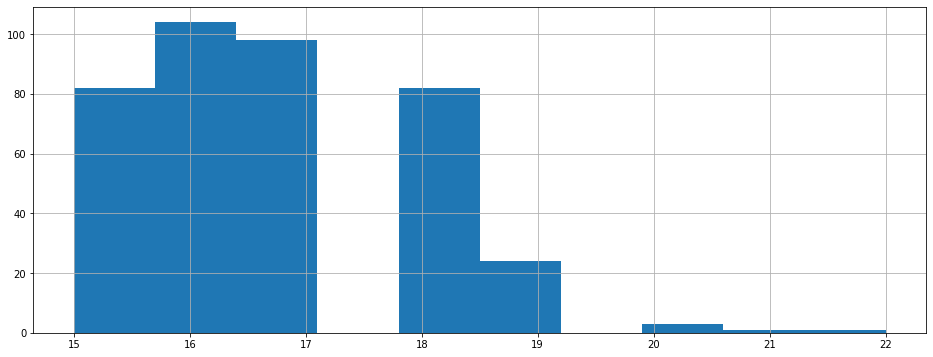

In [65]:
df['age'].hist()

Удалим выбросы.

In [66]:
# Отберем возрастные группы в которых количество участников больше или равно 10
df = filter_statistical_outliers('age', 10)

## medu

Три значений пропущено. Попробуем провести сравнение: соотношение образования отца и матери.

<AxesSubplot:title={'center':'Medu vs Fedu'}, ylabel='Frequency'>

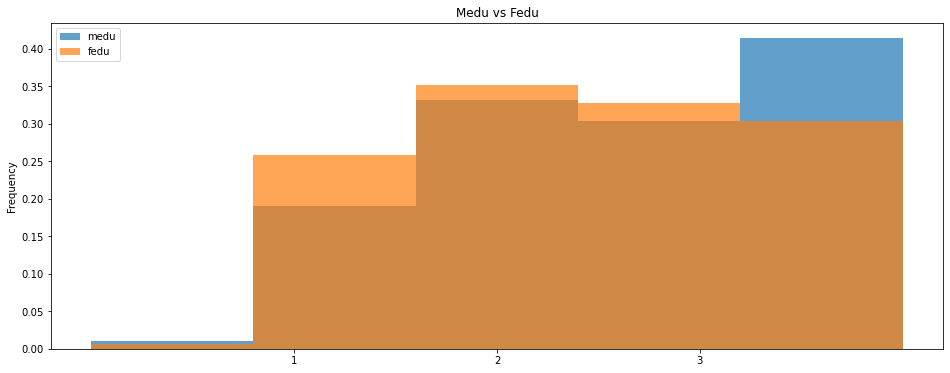

In [67]:
df.loc[(df['medu'] <= 4) & (df['fedu'] <= 4), ['medu', 'fedu']].plot(
    kind='hist',
    bins=5,
    title='Medu vs Fedu',
    alpha=0.7,
    density=True,
    xticks=range(1, 4))

Видно что образование родителей примерно соответствуют друг другу. Можем в пропусках в таблице `medu` указать значение из таблицы `fedu`.

In [68]:
populate_nan_value_from_to('fedu', 'medu')

## fedu

Пропущено 23 значения. Есть одно аномальное значение равное 40. Предположительно это ошибка и человек хотел написать 4, заменим 40 на 4.

In [69]:
df.loc[df['fedu'] == 40, 'fedu'] = 4

На основании предыдущего исследования колонки `medu`: образование родителей примерно соответствуют друг другу. Можем в пропусках в таблице `fedu` указать значение из таблицы `medu`.

In [70]:
populate_nan_value_from_to('medu', 'fedu')

## traveltime

Учащихся далеко от дома меньше всего. Их всего 7. Пока оставим.

## studytime

Учащихся более 4 часов 27 человек, это сильно меньше остальных, но не так уж и мало.

## studytime, granular

После проведенного ранее анализа данной колонки, мы выяснили что данные в колонке `studytime, granular` ни что иное как `studytime` умноженное на -3. Данное утверждение доказано выше в первичном анализе данной колонки. Удалим ее.

In [71]:
df.drop(['studytime, granular'], inplace=True, axis=1)

## failures

Учащихся без неудач сильно больше чем тех, у кого было [1, 2, 3] неудачи. Но в этих группах все же не мало детей. Оставляем как есть.

## famrel

В этой колонке так же присутствует сдвиг, но количество детей в группах [1, 2] не мало. 8 и 17 детей соответственно. Оставляем пока как есть.

## freetime

В этой колонке так же присутствует сдвиг, но количество детей в группах [1] не мало. Оставляем пока как есть.

## absences

В этой колонке есть два значения сильно выделющиеся от остальных: [212, 385]. Посмотрим гистограмму.

<AxesSubplot:>

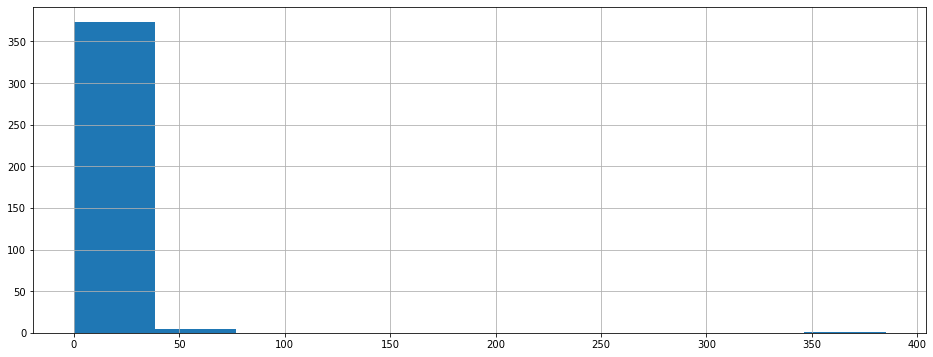

In [72]:
df['absences'].hist()

Колонка содержит выбросы. Отфильтруем данные, удалим выбросы.

In [73]:
take_from, take_to = get_statistical_borders('absences')

<AxesSubplot:>

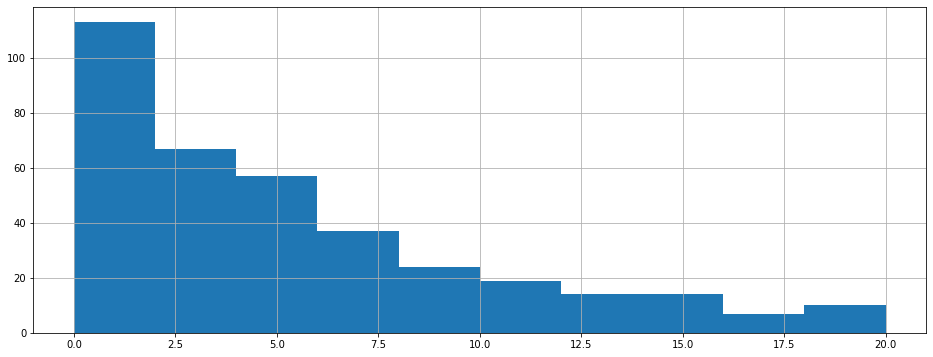

In [74]:
df = df[df['absences'].between(take_from, take_to)]

df['absences'].hist()

## score

По проведенному выше анализу колонки, мы видим что в ней присутствуют NaN и нулевые значения. У многих учащихся с пустым `score` нет предпосылок к плохой оценке. Возможно они пропустили итоговый экзамен или их оценки не были внесены в датасет. Так как это ключевой столбец и удаленных данных будет не более 15%, проще будет удалить пустые значения.

In [75]:
# удалим записи с пустыми значениями в данной колонке
df = df[df['score'] > 0]

# 3. Провести корреляционный анализ количественных переменных.

Выясним, какие столбцы коррелируют с оценкой по математике. Это поможет понять, какие параметры стоит оставить для модели, а какие — исключить.

Корреляции рассмотрим только для числовых столбцов.

Используем для наглядности матрицу корреляций:

С полученной корреляцией построим heatmap для визуализации

<AxesSubplot:>

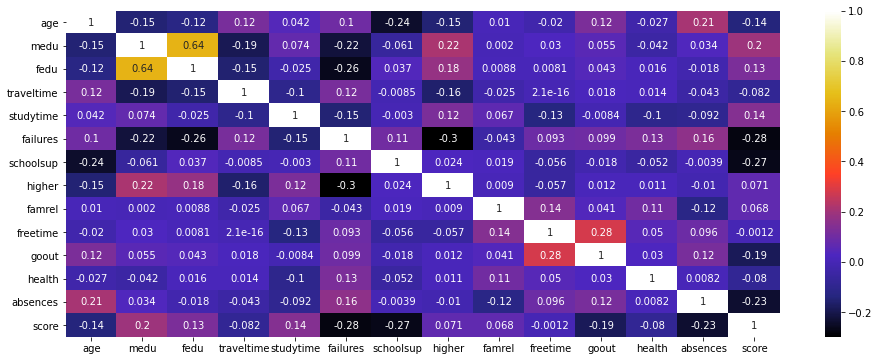

In [76]:
sns.heatmap(df.corr(), cmap="CMRmap", annot=True)

Корреляционный анализ показывает что количество внеучебных неудач, пропусков, длительного прибывания с друзьями и образование матери влияет на успеваемость учащихся больше всего. Так же заметно что с возрастом учпеваемость немного падает. 

# 4. Отобрать не коррелирующие переменные.

Итак, мы видим что **traveltime, famrel, freetime, health** слабо коррелируются со **score**.

# 5. Проанализировать номинативные переменные и устраните те, которые не влияют на предсказываемую величину (`score`)

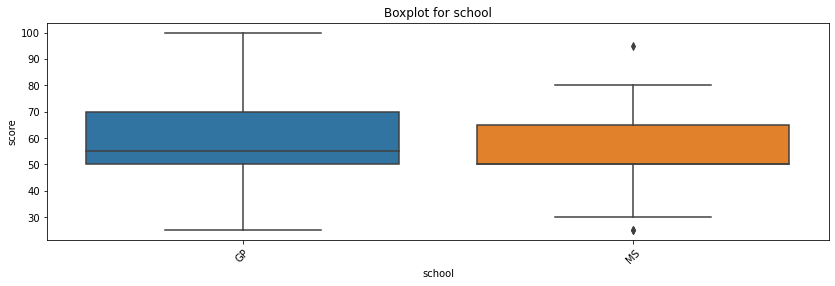

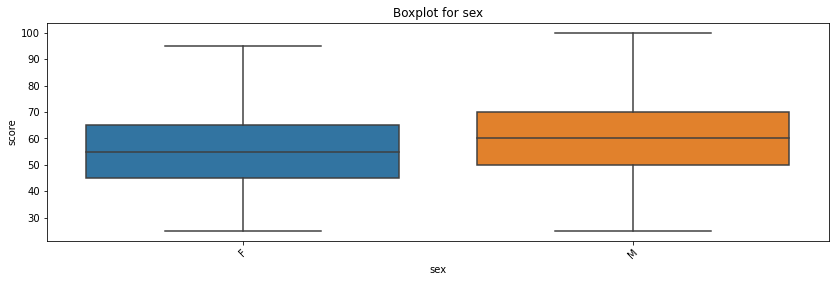

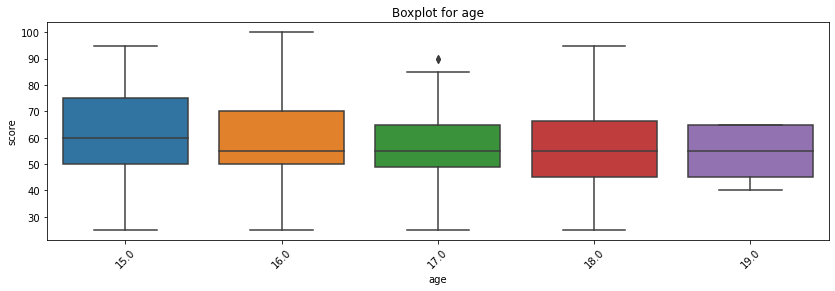

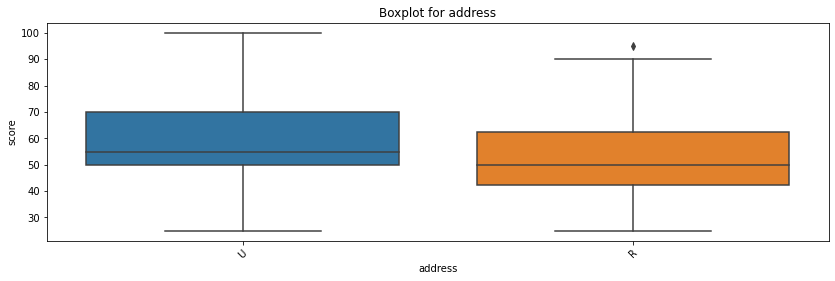

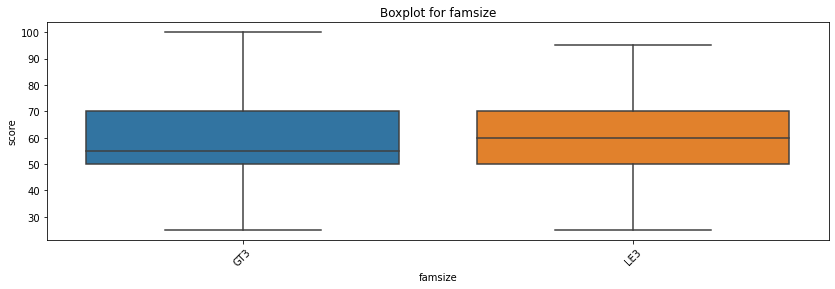

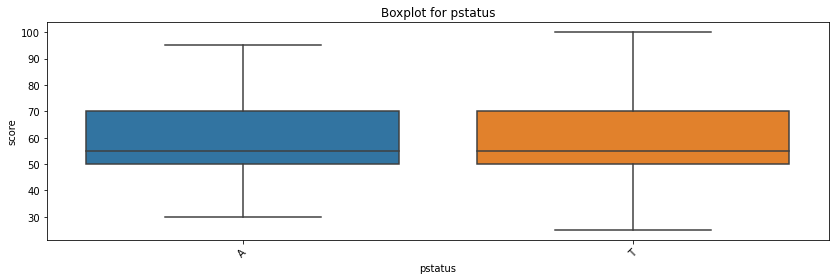

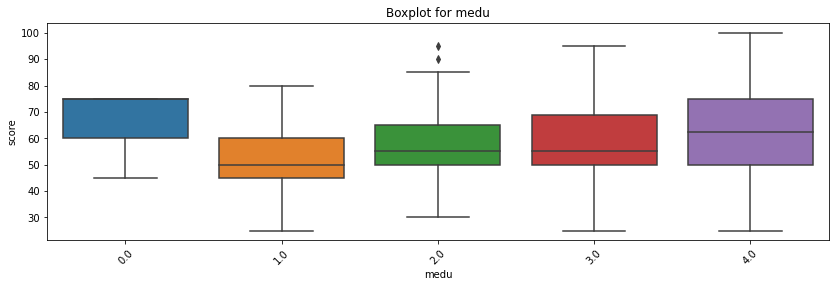

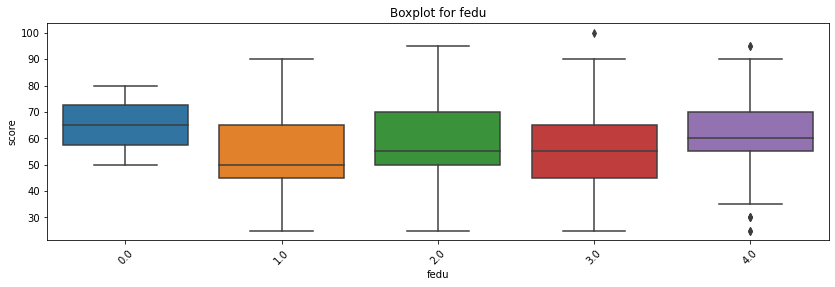

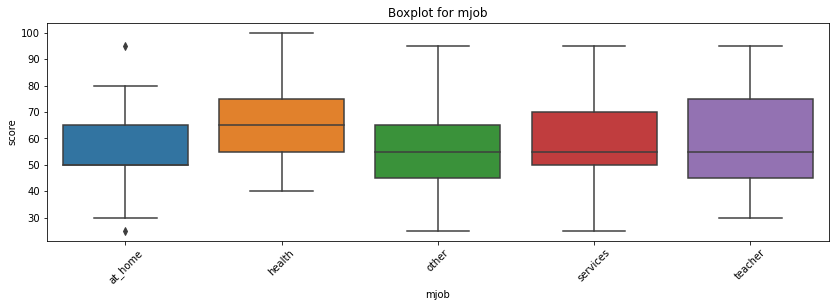

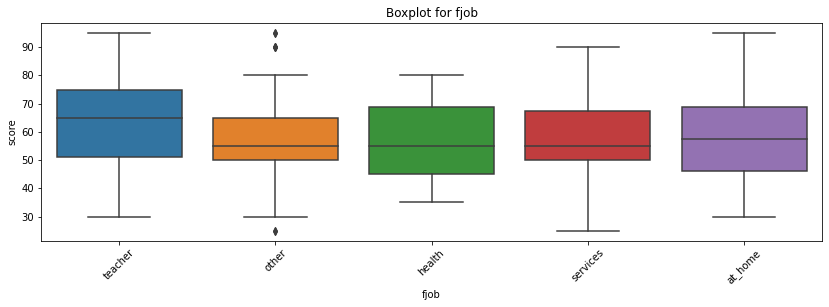

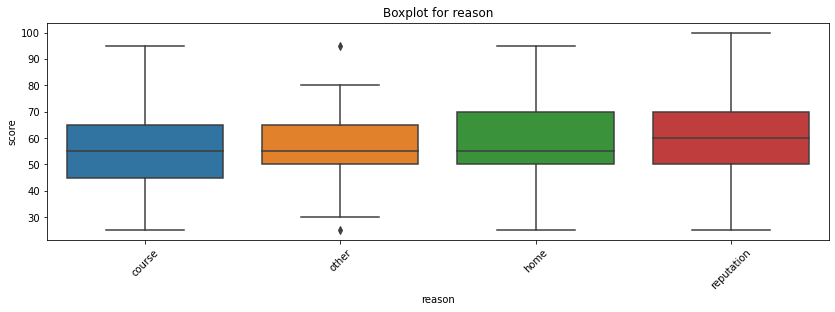

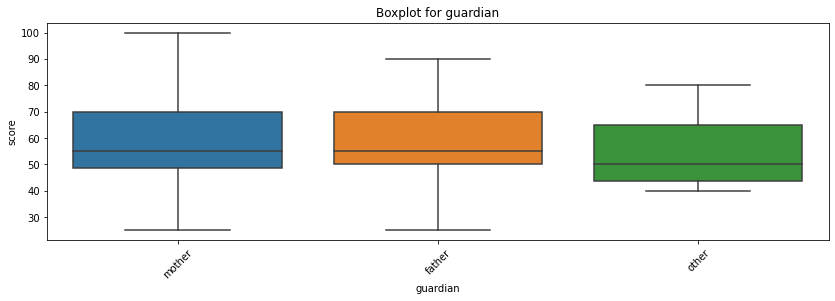

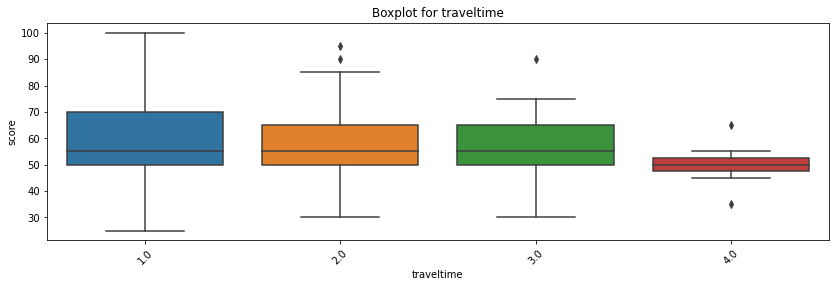

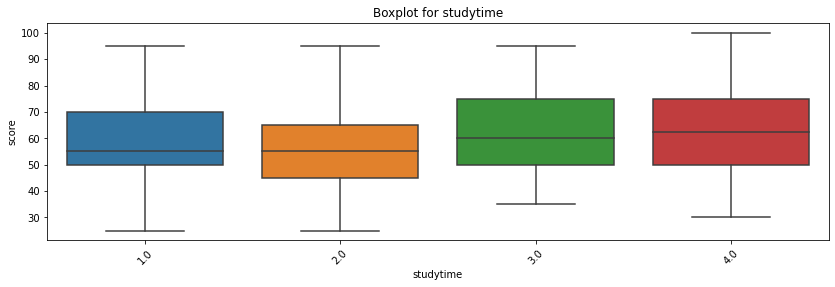

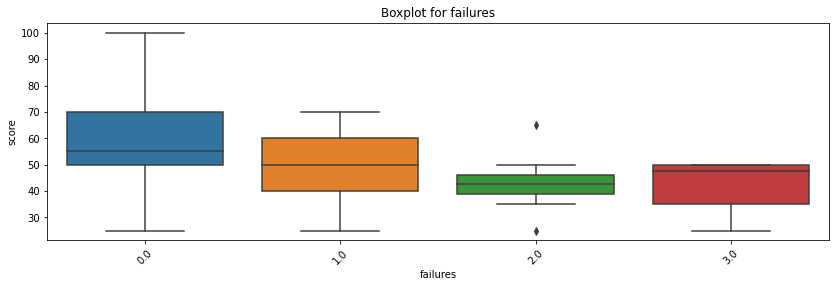

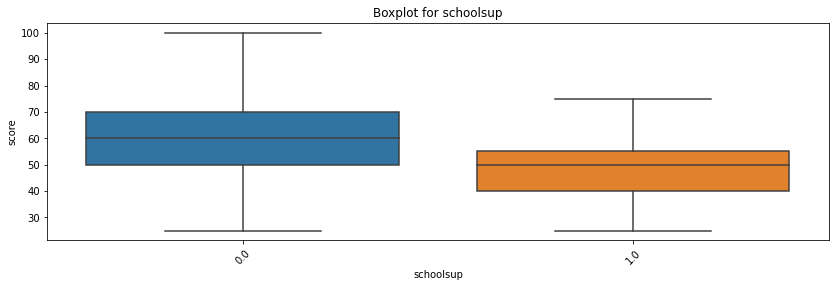

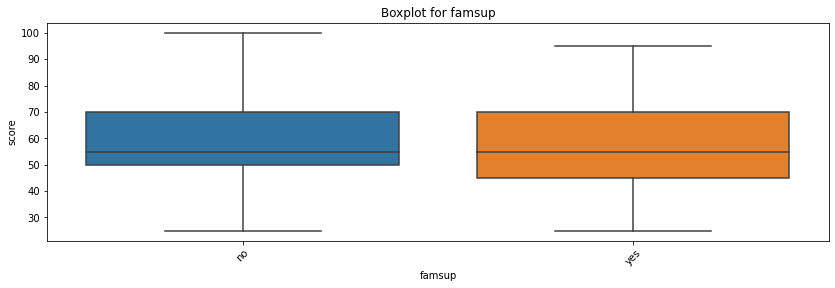

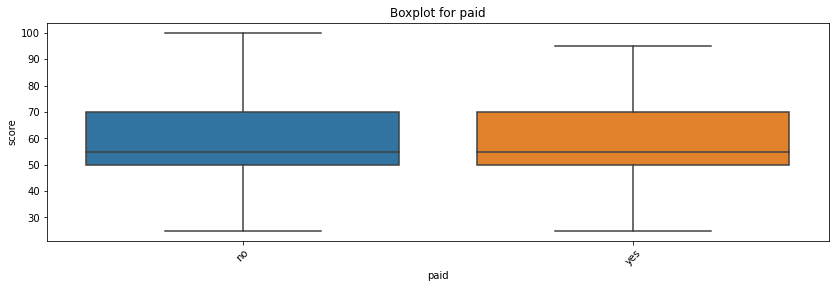

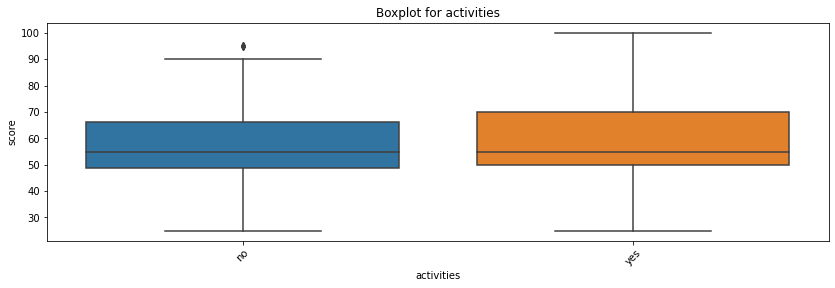

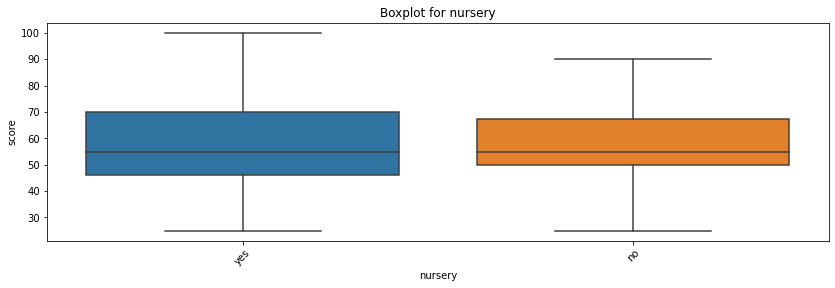

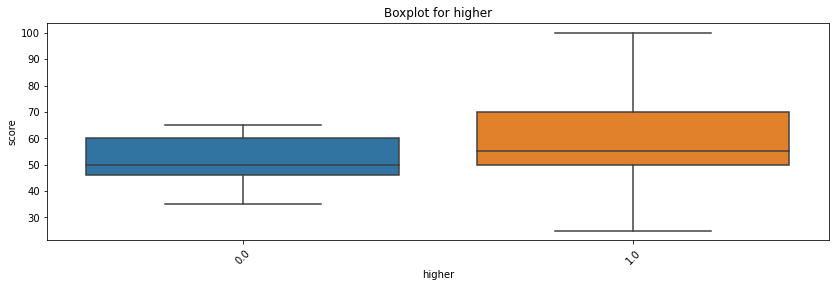

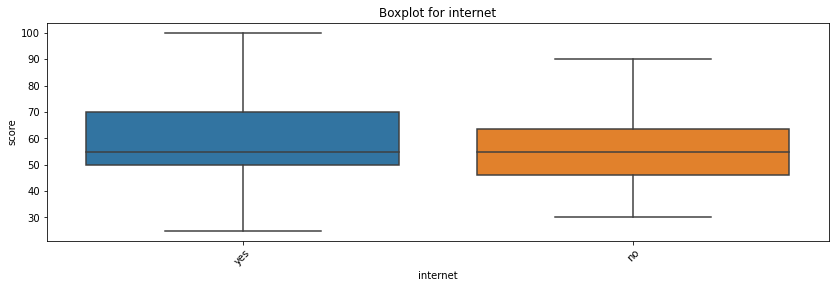

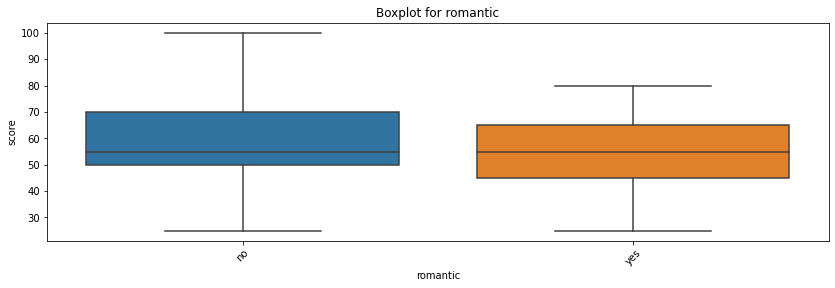

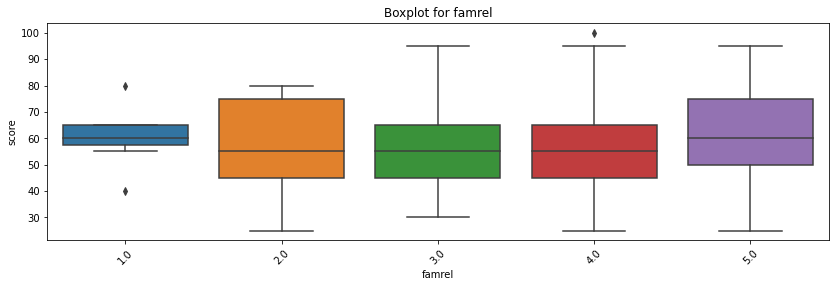

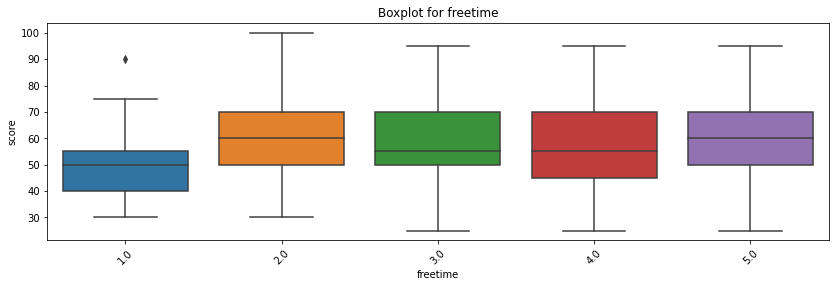

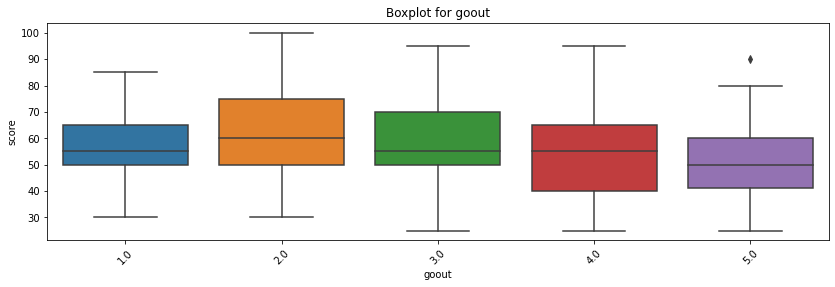

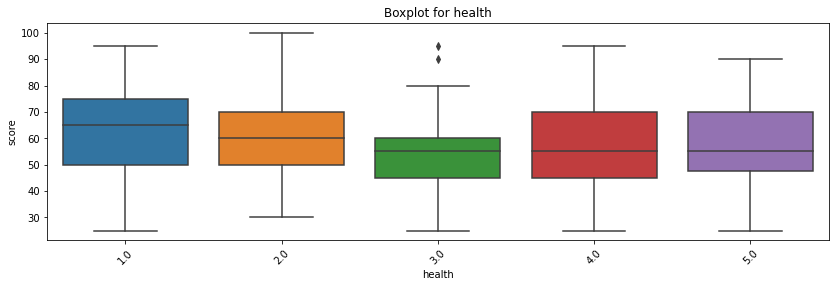

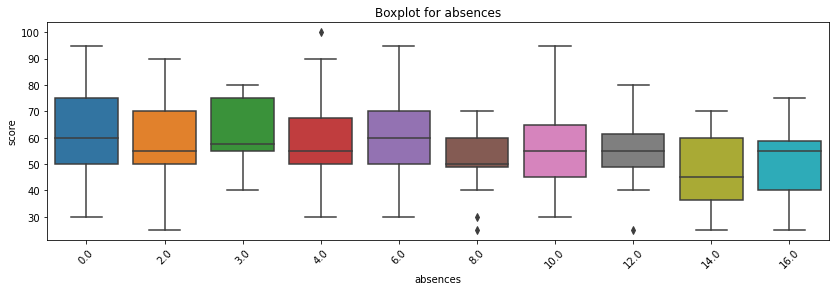

In [77]:
# Сделаем анализ номинативных переменных черех boxplot
for col in df.columns[~df.columns.isin(['score'])]:
    get_boxplot(col)

По графикам видно что следующие колонки: **school, sex, famsize, pstatus, reason, guardian, famsup, paid, activities, nursery, higher, internet, romantic** имеют слабое влияние на оценки или не имеют вовсе.

Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью **теста Стьюдента**. Проверим нулевую гипотезу о том, что распределения оценок батончиков по различным параметрам неразличимы:

In [78]:
for col in df.columns[~df.columns.isin(['score'])]:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки medu
Найдены статистически значимые различия для колонки fedu
Найдены статистически значимые различия для колонки mjob
Найдены статистически значимые различия для колонки studytime
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки schoolsup
Найдены статистически значимые различия для колонки goout


# 6. Сформулировать выводы относительно качества данных и тех переменных, которые будут использоваться в дальнейшем построении модели.

В результате EDA для анализа влияния на успеваемость детей по математике, были выявлены следующие выводы:
В данных достаточно мало пустых значений. Выбросов не много, что позволяет сделать вывод что данные достаточчно чистые.

Что дал нам **тест стьюдента**:
- `sex`: Успеваемость у мальчиков в среднем немного выше чем у девочек.
- `address`: Городские ученики учаться в среднем лучше чем из сельской местности.
- `medu`: Образование матери значительно влияет на успеваемость ребенка.
- `fedu`: Образование отца влияет на успеваемость ребенка меньше чем образование матери. 
- `failures`: Количество учебных неудач (колонка failures) влияет на успеваемость ребенка очень сильно.
- `studytime`: чем больше ученик проводит времени за учебой, тем выше его показатели.
- `goout`: показывает что чрезмерно проведенное время с друзьями как и отсутствие времени проведенного с друзями плохо сказывается на успеваемости.
- `schoolsup`: видно что остающим ученикам нужна школьная поддержка чаще чем тем, кто справляется хорошо.
- `absences`: Данные о количестве пропущенных занятий влияют на конечнуую оценку студента очень сильно.

Но судя по box plot, помимо статистически важных колонок которые показал нам **тест стьюдента**, есть еще колонки которые влияют на **score**: 
- `age`: С возрастом учащиеся начинают учиться немного хуже.
- `higher`: Ученики думающие об высшем образовании в среднем отличаются более высокой успеваемостью.
- `freetime`: ученики у которых совсем мало свободного времени учаться хуже.

Возможные данные которые будут использоваться для модили:
- `sex`
- `age`
- `medu`
- `failures`
- `studytime`
- `goout`
- `address`
- `schoolsup`
- `absences`
- `higher`
- `freetime`
- `score`

In [79]:
df[
    [
        'sex',
        'age',
        'medu',
        'failures',
        'studytime',
        'goout',
        'address',
        'schoolsup',
        'absences',
        'higher',
        'freetime',
        'score'
    ]
].isna().sum()

sex           0
age           0
medu          0
failures     17
studytime     5
goout         6
address      12
schoolsup     8
absences      0
higher       16
freetime      6
score         0
dtype: int64

Так как модель плохо работает с пропущенными значениями, их нужно будет или elfkbnm или привести к средней. По ситуации.